In [1]:
import numpy as np
from numpy.random import rand
import pandas as pd 
from pandas import Series, DataFrame

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb

import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from patsy import dmatrices
from sklearn import datasets, svm

In [2]:
%matplotlib inline
rcParams['figure.figsize'] = 5, 4
sb.set_style('whitegrid')

In [3]:
# read csv data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [4]:
df_train.shape, df_test.shape

((891, 12), (418, 11))

### Descriptive Statistics

In [5]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


Based on the statistics above in the __training set__, we know that about 38% people survived.

### Exploratory Data Analysis (EDA)

Lets visualize  some of the variables within the training data set to get a better understanding of the data.

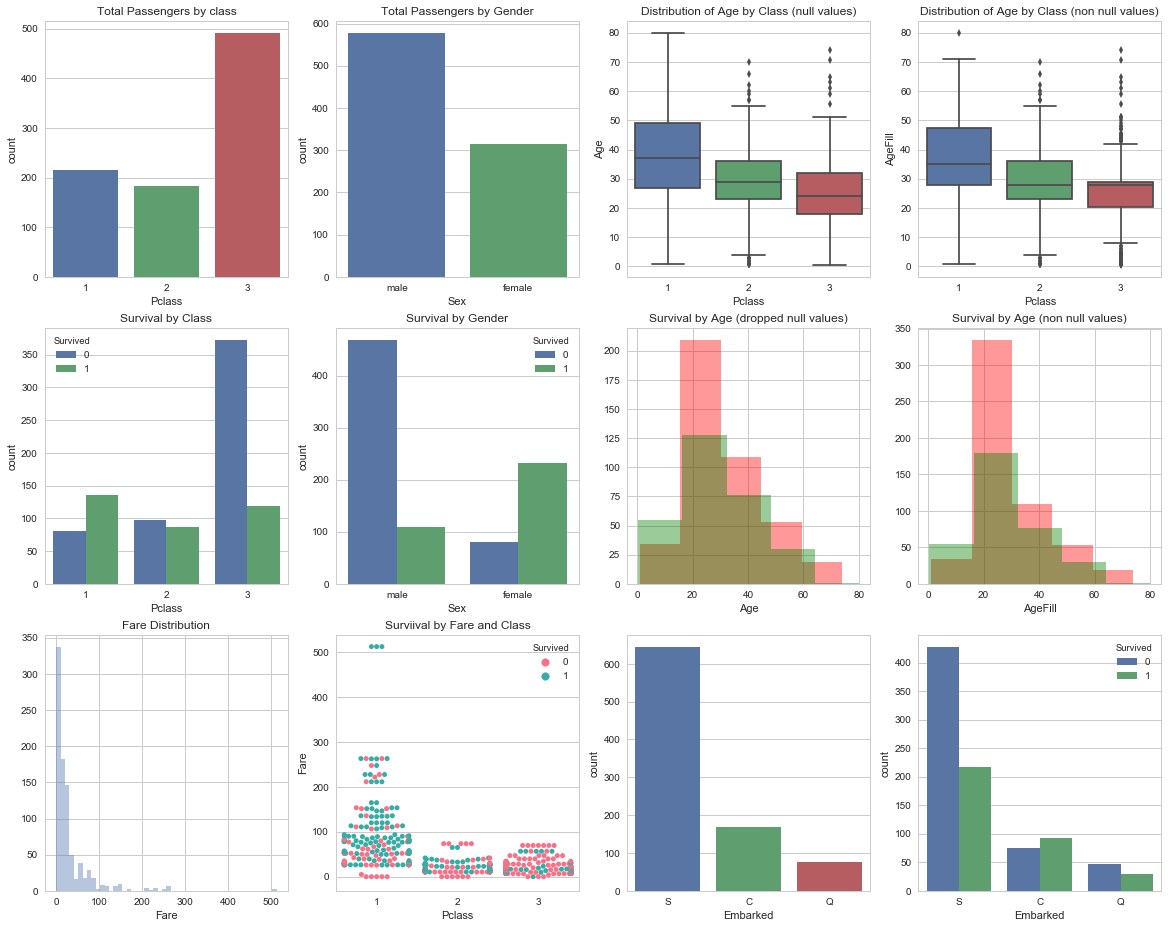

In [7]:
fig,axs = plt.subplots(3,4,figsize=(20,16))

# passengers count by class
sb.countplot('Pclass', data=df_train, ax=axs[0,0])
axs[0,0].set_title('Total Passengers by class')

# passengets count by gender
sb.countplot('Sex', data=df_train, ax=axs[0,1])
axs[0,1].set_title('Total Passengers by Gender')

# a box plot of passenger ages by age
sb.boxplot(x='Pclass', y='Age', data=df_train, ax=axs[0,2])
axs[0,2].set_title('Distribution of Age by Class (null values)')

# age has NaN values, fill this with mean or median
median_age = df_train.Age.median()
median_age = round(median_age, 0)
df_train['AgeFill'] = df_train.Age.fillna(value=median_age)
sb.boxplot(x='Pclass', y='AgeFill', data=df_train, ax=axs[0,3])
ax=axs[0,3].set_title('Distribution of Age by Class (non null values)')

# survival by class
sb.countplot('Pclass', hue='Survived', data=df_train, ax=axs[1,0])
axs[1,0].set_title("Survival by Class")

# survival by gender
sb.countplot('Sex', hue='Survived', data=df_train, ax=axs[1,1])
axs[1,1].set_title("Survival by Gender")

# Age distribution
sb.distplot(df_train[df_train['Survived']==0]['Age'].dropna(), ax=axs[1,2], kde=False, color='r',bins=5)
sb.distplot(df_train[df_train['Survived']==1]['Age'].dropna(), ax=axs[1,2], kde=False, color='g',bins=5)
axs[1,2].set_title("Survival by Age (dropped null values)")

sb.distplot(df_train[df_train['Survived']==0]['AgeFill'], ax=axs[1,3], kde=False, color='r',bins=5)
sb.distplot(df_train[df_train['Survived']==1]['AgeFill'], ax=axs[1,3], kde=False, color='g',bins=5)
axs[1,3].set_title("Survival by Age (non null values)")

# fare distribution
sb.distplot(df_train['Fare'], ax=axs[2,0], kde=False)
axs[2,0].set_title("Fare Distribution")

# # survival by fare and class
sb.swarmplot(x='Pclass',y='Fare',hue='Survived',data=df_train,palette='husl',ax=axs[2,1])
axs[2,1].set_title("Surviival by Fare and Class")

sb.countplot('Embarked', data=df_train, ax=axs[2,2])
sb.countplot('Embarked', hue='Survived', data=df_train, ax=axs[2,3])

### What we learned from exploring the data
* There were mostly class 3 passengers.
* There were more male passengers than female. 
* Older people are generally first class and lower class are younger. 
* Mostly people from class 3 did not survive. 
* Females in general survived more
* Mostly people between age 20-40 died, meaning younger people and older people had higher chance of survival. 
* Most people paid a fare of 100 or less.
* People who paid for the first class fare had a higher chance of survival.
* Most people boarded at Southampton

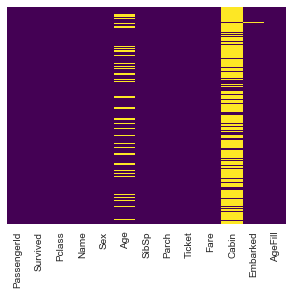

In [8]:
sb.heatmap(df_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [9]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
AgeFill          0
dtype: int64

Based on the code above, both Age and Cabin have NaN values.